# Information Extraction

## Libraries

In [4]:
# libraries
import PyPDF2
import pandas as pd
import nltk
#nltk.download("punkt")
import re

import spacy
# only for datalore 
import subprocess
#%%
print(subprocess.getoutput("python -m spacy download en_core_web_sm"))

nlp = spacy.load("en_core_web_sm")

import textacy
import summa
from summa import keywords

from snorkel.preprocess import preprocessor
from snorkel.types import DataPoint
from itertools import combinations
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier

import networkx as nx
from matplotlib import pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.4/12.8 MB 7.4 MB/s eta 0:00:02
     -- ------------------------------------- 0.9/12.8 MB 9.2 MB/s eta 0:00:02
     ---- ----------------------------------- 1.4/12.8 MB 9.7 MB/s eta 0:00:02
     ----- ---------------------------------- 1.9/12.8 MB 10.1 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/12.8 MB 10.4 MB/s eta 0:00:01
     --------- ------------------------------ 2.9/12.8 MB 11.0 MB/s eta 0:00:01
     ---------- ----------------------------- 3.5/12.8 MB 11.1 MB/s eta 0:00:01
     ------------ --------------------------- 4.0/12.8 MB 11.1 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.8 MB 11.1 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 11.1 MB/s eta 0:00:01
     ----------------- ---------------------- 5.6/12.

## Import Text

In [5]:
# creating a pdf file object
# pdfFileObj = open('The_Shadow_Over_Innsmouth.pdf', 'rb')
pdfFileObj = open('2024.pdf', 'rb')
  
# creating a pdf reader object
pdfReader = PyPDF2.PdfReader(pdfFileObj)

# how many pages
len(pdfReader.pages)

print(len(pdfReader.pages))

# creating a page object
pageObj = pdfReader.pages
  
# extracting text from page
# loop here to get it all 
text = []
for page in pageObj:
  text.append(page.extract_text())

# closing the pdf file object
pdfFileObj.close()

18


## Convert to Sentences and Pandas
-	^ means start with
-	[0-9] means any of these digits
-	[a-zA-Z] means any alpha latin character lower or upper case
-	$ ends with
-	. mean any character
	
    o	means zero or more of the previous character (so .* means zero or more of any character)


In [7]:
# create a place to save the text
saved_words = []

# Joining the extracted text pages into a single string
book = ' '.join(text)

# loop over each word
for word in nltk.word_tokenize(book):
    # if the word starts with a number and ends with a letter
    if (re.search(r'^[0-9].*[a-zA-Z]$', word) != "None"): 
        # take out the numbers and save into our text
        saved_words.append(re.sub(r'[0-9]', '', word))
    # if not then save just the word 
    else:
        saved_words.append(word)

book =' '.join(saved_words)

DF = pd.DataFrame(
    nltk.sent_tokenize(book),
    columns = ["sentences"]
)

DF.head()

# for IE, we want sentence and/or paragraph level structure 

,sentences
0,Data science interview questions and answers f...
1,We encourage you to go through the curated lis...
2,Apply as data scientists I 'm hiring developer...
3,"As a vast field , with plenty of demand , both..."
4,"Hence , to prepare both parties , we have cura..."


## Part of Speech Tagging

-	Tag your data with spacy’s part of speech tagger.
-	Convert this data into a Pandas DataFrame.


In [8]:
# easier to loop over the big text file than loop over words AND rows in pandas 
spacy_pos_tagged = [(str(word), word.tag_, word.pos_) for word in nlp(book)]
# each row represents one token 
DF_POS = pd.DataFrame(
    spacy_pos_tagged,
    columns = ["token", "specific_tag", "upos"]
)

- Use the dataframe to calculate the most common parts of speech.

In [9]:
DF_POS['upos'].value_counts()

upos
NOUN     1223
PUNCT     526
VERB      514
DET       466
ADP       428
ADJ       340
AUX       301
PROPN     229
PRON      168
CCONJ     137
PART       92
ADV        72
SCONJ      68
NUM        55
SPACE      45
X          16
SYM         9
INTJ        8
Name: count, dtype: int64

-	Use the dataframe to calculate if words are considered more than one part of speech (crosstabs or groupby).

In [10]:
DF_POS2 = pd.crosstab(DF_POS['token'], DF_POS['upos'])
# convert to true false to add up how many times not zero 
DF_POS2['total'] = DF_POS2.astype(bool).sum(axis=1)
#print out the rows that aren't 1 
DF_POS2[DF_POS2['total'] > 1]

upos,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X,total
token,,,,,,,,,,,,,,,,,,,
+,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2
-,0,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,0,0,2
-based,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
-means,0,0,0,0,0,0,0,2,0,0,0,3,0,0,0,0,0,0,2
-square,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
to,0,25,0,0,0,0,0,0,0,79,0,0,0,0,0,0,0,0,2
training,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,4,0,2
use,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10,0,2


-	What is the most common part of speech? ANSWER THIS IN YOUR TEXT
-	Do you see words that are multiple parts of speech? ANSWER THIS IN YOUR TEXT

## KPE
-	Use textacy to find the key phrases in your text.
    
    o	in the r window for r people

    o	library(reticulate)

    o	py_install("networkx < 3.0", pip = T)



In [11]:
# textacy KPE
# build an english language for textacy pipe
en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser"))

# build a processor for textacy using spacy and process text
doc = textacy.make_spacy_doc(book, lang = en)

# text rank algorithm  
print([kps for kps, weights in textacy.extract.keyterms.textrank(doc, normalize = "lemma",  topn = 5)])

terms = set([term for term, weight in textacy.extract.keyterms.textrank(doc)])
print(textacy.extract.utils.aggregate_term_variants(terms))

['content Basic datum science interview question', 'datum science technical interview question', 'intermediate datum science interview question', 'advanced datum science interview question', 'datum science job']
[{'content Basic datum science interview question'}, {'intermediate datum science interview question'}, {'datum science technical interview question'}, {'advanced datum science interview question'}, {'exploratory datum analysis'}, {'datum science application'}, {'datum science life cycle'}, {'different datum type'}, {'datum science job'}, {'sample datum'}]


•	Use summa to find the key phrases in your text.

In [12]:
TR_keywords = keywords.keywords(book, scores = True)
print(TR_keywords[0:10])

[('data science interview questions', 0.22221301412918812), ('sampling', 0.14684813577795505), ('sample', 0.14684813577795505), ('samplings', 0.14684813577795505), ('samples', 0.14684813577795505), ('variables', 0.14487282640726087), ('variable', 0.14487282640726087), ('values', 0.1339291369649484), ('value', 0.1339291369649484), ('methods', 0.12859857435603242)]


-	What differences do you see in their outputs? COMMENT ON HOW SLOW!
-	Using textacy utilities, combine like key phrases. SEE ABOVE
-	Do the outputs make sense given your text? ANSWER THIS QUESTION

## NER + Snorkel
-	Use spacy to extract named entities.
-	Create a summary of your named entities.


In [14]:
# easier to loop over the big text file than loop over words AND rows in pandas 
spacy_ner_tagged = [(str(word.text), word.label_) for word in nlp(book).ents]

# each row represents one token 
DF_NER = pd.DataFrame(
    spacy_ner_tagged,
    columns = ["token", "entity"]
)
print(DF_NER['entity'].value_counts())

DF_NER2 = pd.crosstab(DF_NER['token'], DF_NER['entity'])
print(DF_NER2)

# convert to true false to add up how many times not zero 
DF_NER2['total'] = DF_NER2.astype(bool).sum(axis=1)
#print out the rows that aren't 1 
DF_NER2[DF_NER2['total'] > 1]

entity
ORG            38
CARDINAL       30
PERSON         14
PRODUCT        10
GPE             9
NORP            3
WORK_OF_ART     3
LOC             2
ORDINAL         2
DATE            2
EVENT           1
Name: count, dtype: int64
entity                                              CARDINAL  DATE  EVENT  \
token                                                                       
AI                                                         0     0      0   
ANOVA                                                      0     0      0   
Algorithm                                                  0     0      0   
Apply Now INTERMEDIATE DATA SCIENCE INTERVIEW Q...         0     0      0   
Apply Now WRAPPING UP                                      0     0      1   
...                                                      ...   ...    ...   
• Non                                                      0     0      0   
• Recursive                                                0     0      0   

entity,CARDINAL,DATE,EVENT,GPE,LOC,NORP,ORDINAL,ORG,PERSON,PRODUCT,WORK_OF_ART,total
token,,,,,,,,,,,,
Data Science,0,0,0,0,0,0,0,1,1,0,0,2


-	Apply Snorkel to your data to show any relationship between names.
## get the data into a good format


In [15]:
stored_entities = []

# first get the entities, must be two for relationship matches
def get_entities(x):
  """
  Grabs the names using spacy's entity labeler
  """
  # get all the entities in this row 
  processed = nlp(x)
  # get the tokens for each sentence
  tokens = [word.text for word in processed]
  # get all the entities - notice this is only for persons 
  temp = [(str(ent), ent.label_) for ent in processed.ents if ent.label_ != ""]
  # only move on if this row has at least two
  if len(temp) > 1: 
    # finds all the combinations of pairs 
    temp2 = list(combinations(temp, 2))
    # for each pair combination 
    for (person1, person2) in temp2:
      # find the names in the person 1
      person1_words = [word.text for word in nlp(person1[0])]
      # find the token numbers for person 1
      person1_ids = [i for i, val in enumerate(tokens) if val in person1_words]
      # output in (start, stop) token tuple format 
      if len(person1_words) > 1:
        person1_ids2 = tuple(idx for idx in person1_ids[0:2])
      else:
        id_1 = [idx for idx in person1_ids]
        person1_ids2 = (id_1[0], id_1[0])
        
      # do the same thing with person 2
      person2_words = [word.text for word in nlp(person2[0])]
      person2_ids = [i for i, val in enumerate(tokens) if val in person2_words[0:2]]
      if len(person2_words) > 1:
        person2_ids2 = tuple(idx for idx in person2_ids)
      else:
        id_2 = [idx for idx in person2_ids[0:2]]
        person2_ids2 = (id_2[0], id_2[0])  
      
      # store all this in a list 
      stored_entities.append(
        [x, # original text
        tokens, # tokens
        person1[0], # person 1 name
        person2[0], # person 2 name
        person1_ids2, # person 1 id token tuple 
        person2_ids2 # person 2 id token tuple
        ])

DF['sentences'].apply(get_entities)

# create dataframe in snorkel structure 
DF_dev = pd.DataFrame(stored_entities, columns = ["sentence", "tokens", "person1", "person2", "person1_word_idx", "person2_word_idx"])


## figure out where to look (between and to the left)

In [16]:
# live locate home road roads in at street (locations tied together)
# family terms for people 

# get words between the data points 
@preprocessor()
def get_text_between(cand: DataPoint) -> DataPoint:
    """
    Returns the text between the two person mentions in the sentence
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.between_tokens = cand.tokens[start:end]
    return cand

# get words next to the data points
@preprocessor()
def get_left_tokens(cand: DataPoint) -> DataPoint:
    """
    Returns tokens in the length 3 window to the left of the person mentions
    """
    # TODO: need to pass window as input params
    window = 5

    end = cand.person1_word_idx[0]
    cand.person1_left_tokens = cand.tokens[0:end][-1 - window : -1]

    end = cand.person2_word_idx[0]
    cand.person2_left_tokens = cand.tokens[0:end][-1 - window : -1]
    return cand

## figure out what to look for

In [17]:
# live locate home road roads in at street (locations tied together)
# family terms for people 

found_location = 1
found_family = -1
ABSTAIN = 0

location = {"live", "living", "locate", "located", "home", "road", "roads", "street", "streets", "in", "at", "of"}

@labeling_function(resources=dict(location=location), pre=[get_text_between])
def between_location(x, location):
    return found_location if len(location.intersection(set(x.between_tokens))) > 0 else ABSTAIN

@labeling_function(resources=dict(location=location), pre=[get_left_tokens])
def left_location(x, location):
    if len(set(location).intersection(set(x.person1_left_tokens))) > 0:
        return found_location
    elif len(set(location).intersection(set(x.person2_left_tokens))) > 0:
        return found_location
    else:
        return ABSTAIN

family = {"spouse", "wife", "husband", "ex-wife", "ex-husband", "marry", 
          "married", "father", "mother", "sister", "brother", "son", "daughter", 
          "grandfather", "grandmother", "uncle", "aunt", "cousin", 
          "boyfriend", "girlfriend"}

@labeling_function(resources=dict(family=family), pre=[get_text_between])
def between_family(x, family):
    return found_family if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN

@labeling_function(resources=dict(family=family), pre=[get_left_tokens])
def left_family(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return found_family
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return found_family
    else:
        return ABSTAIN

# create a list of functions to run     
lfs = [
    between_location,
    left_location,
    between_family,
    left_family
]
# build the applier function 
applier = PandasLFApplier(lfs)
# run it on the dataset 
L_dev = applier.apply(DF_dev)

100%|██████████| 49/49 [00:00<00:00, 669.47it/s]


In [18]:
L_dev

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0,

In [19]:
DF_combined = pd.concat([DF_dev, pd.DataFrame(L_dev, columns = ["location1", "location2", "family1", "family2"])], axis = 1)
DF_combined

,sentence,tokens,person1,person2,person1_word_idx,person2_word_idx,location1,location2,family1,family2
0,The two main sampling techniques used as per s...,"[The, two, main, sampling, techniques, used, a...",two,• Non,"(1, 1)","(12, 26, 27)",0,0,0,0
1,"Structured , semi -structured , and unstructur...","[Structured, ,, semi, -structured, ,, and, uns...",Structured,three,"(0, 0)","(10, 10)",0,0,0,0
2,"Volume , Velocity , Variety , Veracity , and V...","[Volume, ,, Velocity, ,, Variety, ,, Veracity,...",Value,five,"(9, 9)","(12, 12)",0,0,0,0
3,"NLP stands for Natural Language Processing , w...","[NLP, stands, for, Natural, Language, Processi...",NLP,Natural Language Processing,"(0, 0)","(3, 4)",0,0,0,0
4,Correlation and covariance are two measures of...,"[Correlation, and, covariance, are, two, measu...",two,two,"(4, 4)","(4, 4)",0,0,0,0
5,Correlation is a measure of how two variables ...,"[Correlation, is, a, measure, of, how, two, va...",two,two,"(6, 6)","(6, 6)",0,1,0,0
6,The Hamming distance and the Levenshtein dista...,"[The, Hamming, distance, and, the, Levenshtein...",Levenshtein,two,"(5, 5)","(8, 8)",0,0,0,0
7,The Hamming distance and the Levenshtein dista...,"[The, Hamming, distance, and, the, Levenshtein...",Levenshtein,two,"(5, 5)","(8, 8)",0,0,0,0
8,The Hamming distance and the Levenshtein dista...,"[The, Hamming, distance, and, the, Levenshtein...",two,two,"(8, 8)","(8, 8)",0,0,0,0
9,The number of bits that differ between two str...,"[The, number, of, bits, that, differ, between,...",two,Hamming,"(7, 7)","(13, 13)",0,1,0,0


In [20]:
DF_combined['location_yes'] = DF_combined['location1'] + DF_combined["location2"]
DF_combined['family_yes'] = DF_combined['family1'] + DF_combined["family2"]

print(DF_combined['location_yes'].value_counts())
print(DF_combined['family_yes'].value_counts())
print(DF_combined.head())
DF_combined.to_csv('family_check.csv', index=False)

location_yes
0    35
1     9
2     5
Name: count, dtype: int64
family_yes
0    49
Name: count, dtype: int64
                                            sentence  \
0  The two main sampling techniques used as per s...   
1  Structured , semi -structured , and unstructur...   
2  Volume , Velocity , Variety , Veracity , and V...   
3  NLP stands for Natural Language Processing , w...   
4  Correlation and covariance are two measures of...   

                                              tokens     person1  \
0  [The, two, main, sampling, techniques, used, a...         two   
1  [Structured, ,, semi, -structured, ,, and, uns...  Structured   
2  [Volume, ,, Velocity, ,, Variety, ,, Veracity,...       Value   
3  [NLP, stands, for, Natural, Language, Processi...         NLP   
4  [Correlation, and, covariance, are, two, measu...         two   

                       person2 person1_word_idx person2_word_idx  location1  \
0                        • Non           (1, 1)     (12, 26, 27)   

-	What might you do to improve the default NER extraction?
## Knowledge Graphs
### Slides Version
-	Based on the chosen text, add entities to a default spacy model.
-	Add a norm_entity, merge_entity, and init_coref pipelines.
-	Update and add the alias lookup if necessary for the data.
-	Add the name resolver pipeline.
### Or Use Your Snorkel Output
-	Create a co-occurrence graph of the entities linked together in your text.


In [21]:
# locations only
DF_loc = DF_combined[DF_combined['location_yes'] > 0]
DF_loc = DF_loc[['person1', 'person2']].reset_index(drop = True)

cooc_loc = DF_loc.groupby(by=["person1", "person2"], as_index=False).size()

# family only
DF_combined['family_yes'] = DF_combined['family_yes'].abs()

DF_fam = DF_combined[DF_combined['family_yes'] > 0]
DF_fam = DF_fam[['person1', 'person2']].reset_index(drop = True)

#print(DF_fam.head())

cooc_fam = DF_fam.groupby(by=["person1", "person2"], as_index=False).size()

# take out issues where entity 1 == entity 2
cooc_loc = cooc_loc[cooc_loc['person1'] != cooc_loc['person2']]
cooc_fam = cooc_fam[cooc_fam['person1'] != cooc_fam['person2']]

print(cooc_loc.head())
print(cooc_fam.head())

                                             person1     person2  size
0                                          Bivariate         two     1
1                                      Build Looking          US     1
2                                            Nunique  PostgreSQL     1
3                                                ROC          US     1
4  SELECT Name FROM StudentData WHERE Department ...       three     1
Empty DataFrame
Columns: [person1, person2, size]
Index: []


-	This creates a dataframe of node 1 and then node 2 (entity 1 to entity 2) and then frequency (size)

In [22]:
# start by plotting the whole thing for location 
# cooc_loc_small = cooc_loc[cooc_loc['size']>1]
# graph = nx.from_pandas_edgelist(
#            cooc_loc_small[['person1', 'person2', 'size']] \
#            .rename(columns={'size': 'weight'}),
#            source='person1', target='person2', edge_attr=True)

# pos = nx.kamada_kawai_layout(graph, weight='weight')

# _ = plt.figure(figsize=(20, 20))
# nx.draw(graph, pos, 
#         node_size=1000, 
#         node_color='skyblue',
#         alpha=0.8,
#         with_labels = True)
# plt.title('Graph Visualization', size=15)

# for (node1,node2,data) in graph.edges(data=True):
#     width = data['weight'] 
#     _ = nx.draw_networkx_edges(graph,pos,
#                                edgelist=[(node1, node2)],
#                                width=width,
#                                edge_color='#505050',
#                                alpha=0.5)

# plt.show()
# plt.close()

In [23]:
# # start by plotting the whole thing for location 
# graph = nx.from_pandas_edgelist(
#            cooc_fam[['person1', 'person2', 'size']] \
#            .rename(columns={'size': 'weight'}),
#            source='person1', target='person2', edge_attr=True)

# pos = nx.kamada_kawai_layout(graph, weight='weight')

# _ = plt.figure(figsize=(20, 20))
# nx.draw(graph, pos, 
#         node_size=1000, 
#         node_color='skyblue',
#         alpha=0.8,
#         with_labels = True)
# plt.title('Graph Visualization', size=15)

# for (node1,node2,data) in graph.edges(data=True):
#     width = data['weight'] 
#     _ = nx.draw_networkx_edges(graph,pos,
#                                edgelist=[(node1, node2)],
#                                width=width,
#                                edge_color='#505050',
#                                alpha=0.5)

# plt.show()
# plt.close()

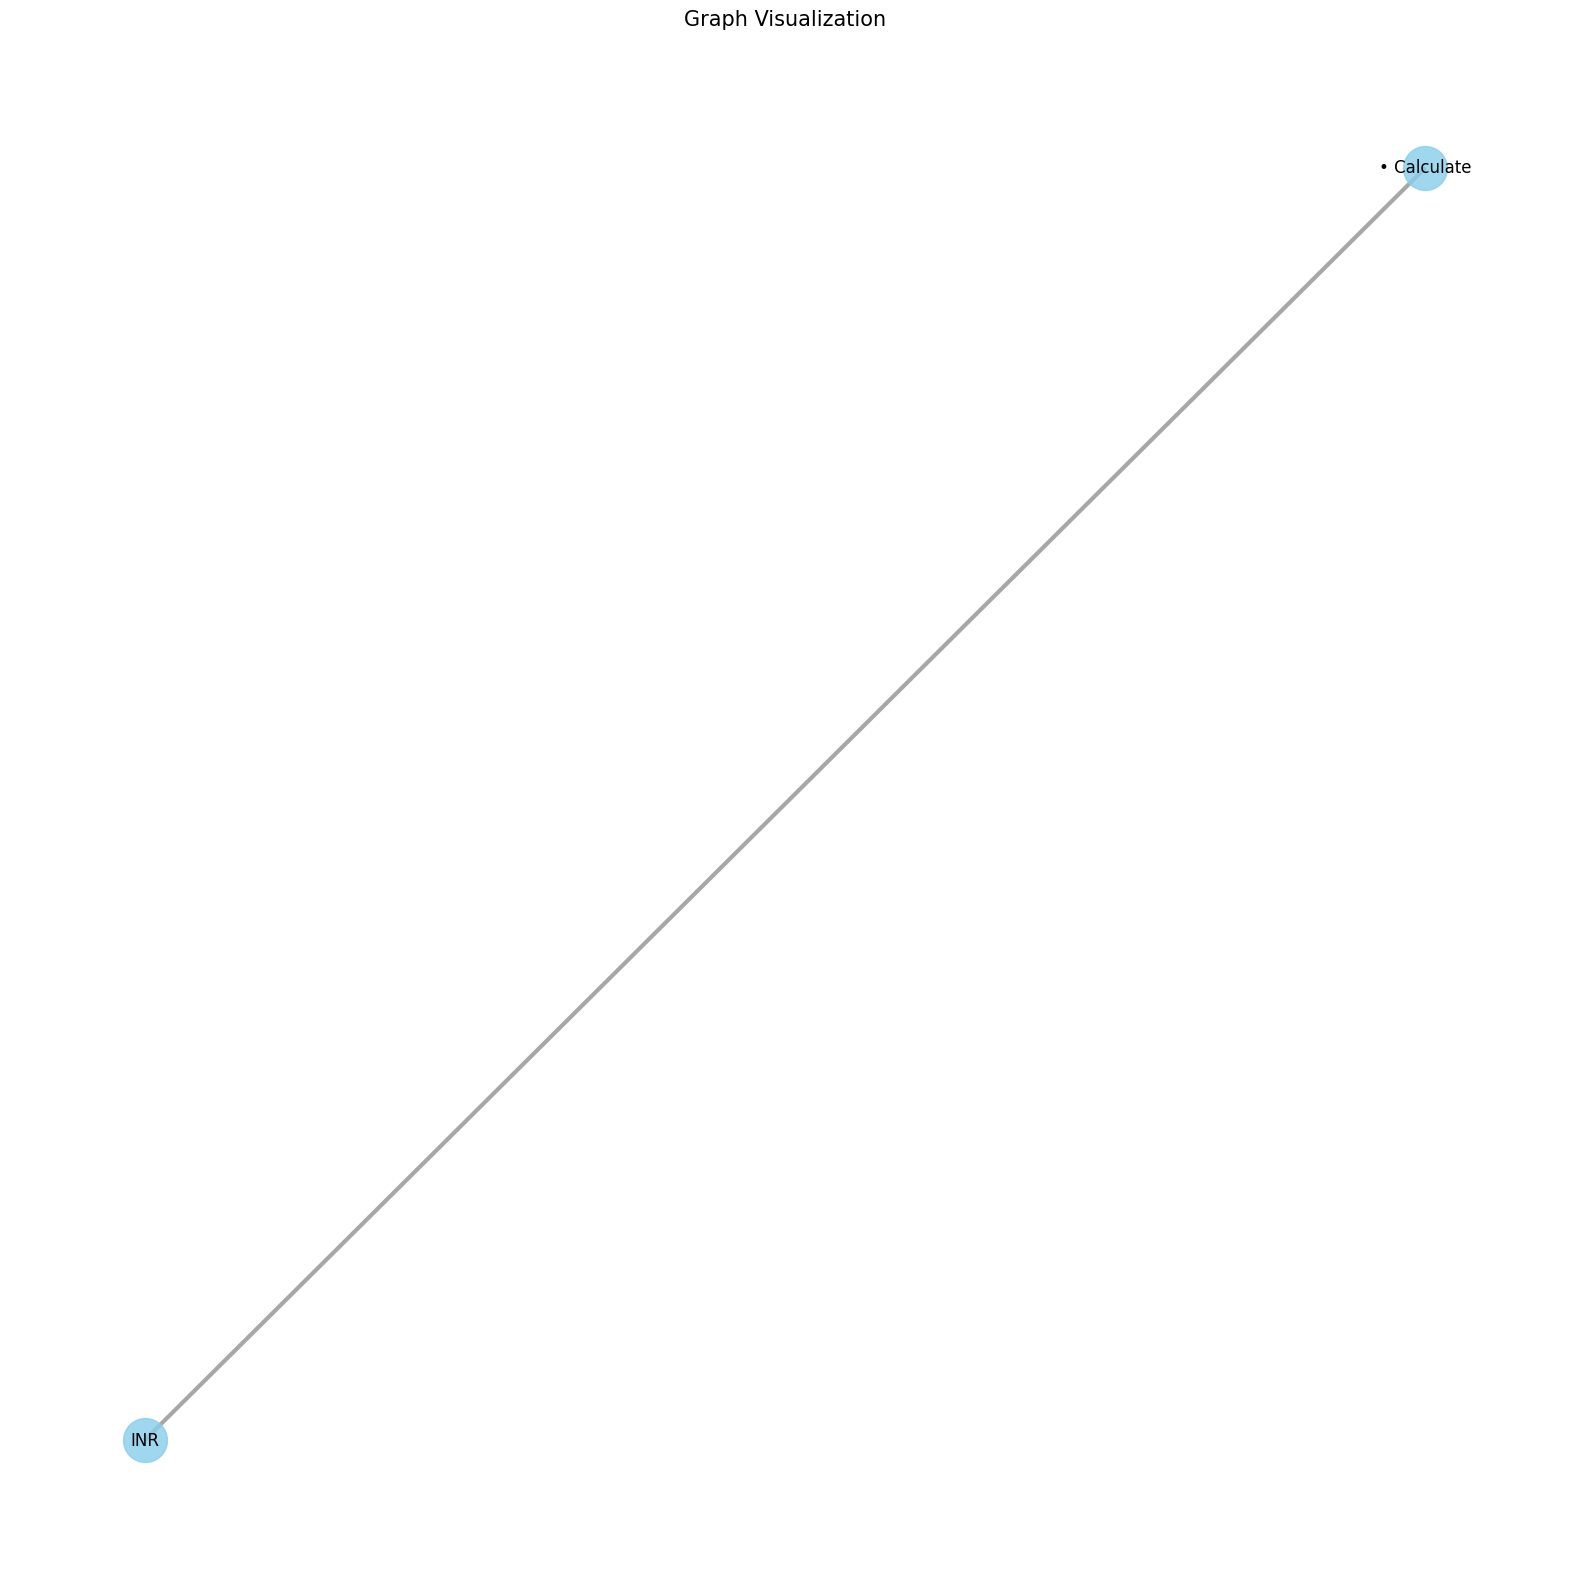

In [24]:
# Filter the data
cooc_loc_small = cooc_loc[cooc_loc['size'] > 1]

# Create the graph from the filtered dataframe
graph = nx.from_pandas_edgelist(
    cooc_loc_small,
    source='person1',
    target='person2',
    edge_attr='size'
)

# Generate positions for each node using Kamada-Kawai layout considering the edge weights
pos = nx.kamada_kawai_layout(graph, weight='size')

# Plotting
plt.figure(figsize=(20, 20))
# Draw nodes
nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color='skyblue', alpha=0.8)
# Draw labels
nx.draw_networkx_labels(graph, pos)
# Draw edges
edges = nx.draw_networkx_edges(graph, pos, edge_color='#505050', alpha=0.5, 
                               width=[data['size'] for _, _, data in graph.edges(data=True)])

plt.title('Graph Visualization', size=15)
plt.axis('off')  # Turn off the axis
plt.show()

In [25]:
print(cooc_fam.head())

Empty DataFrame
Columns: [person1, person2, size]
Index: []


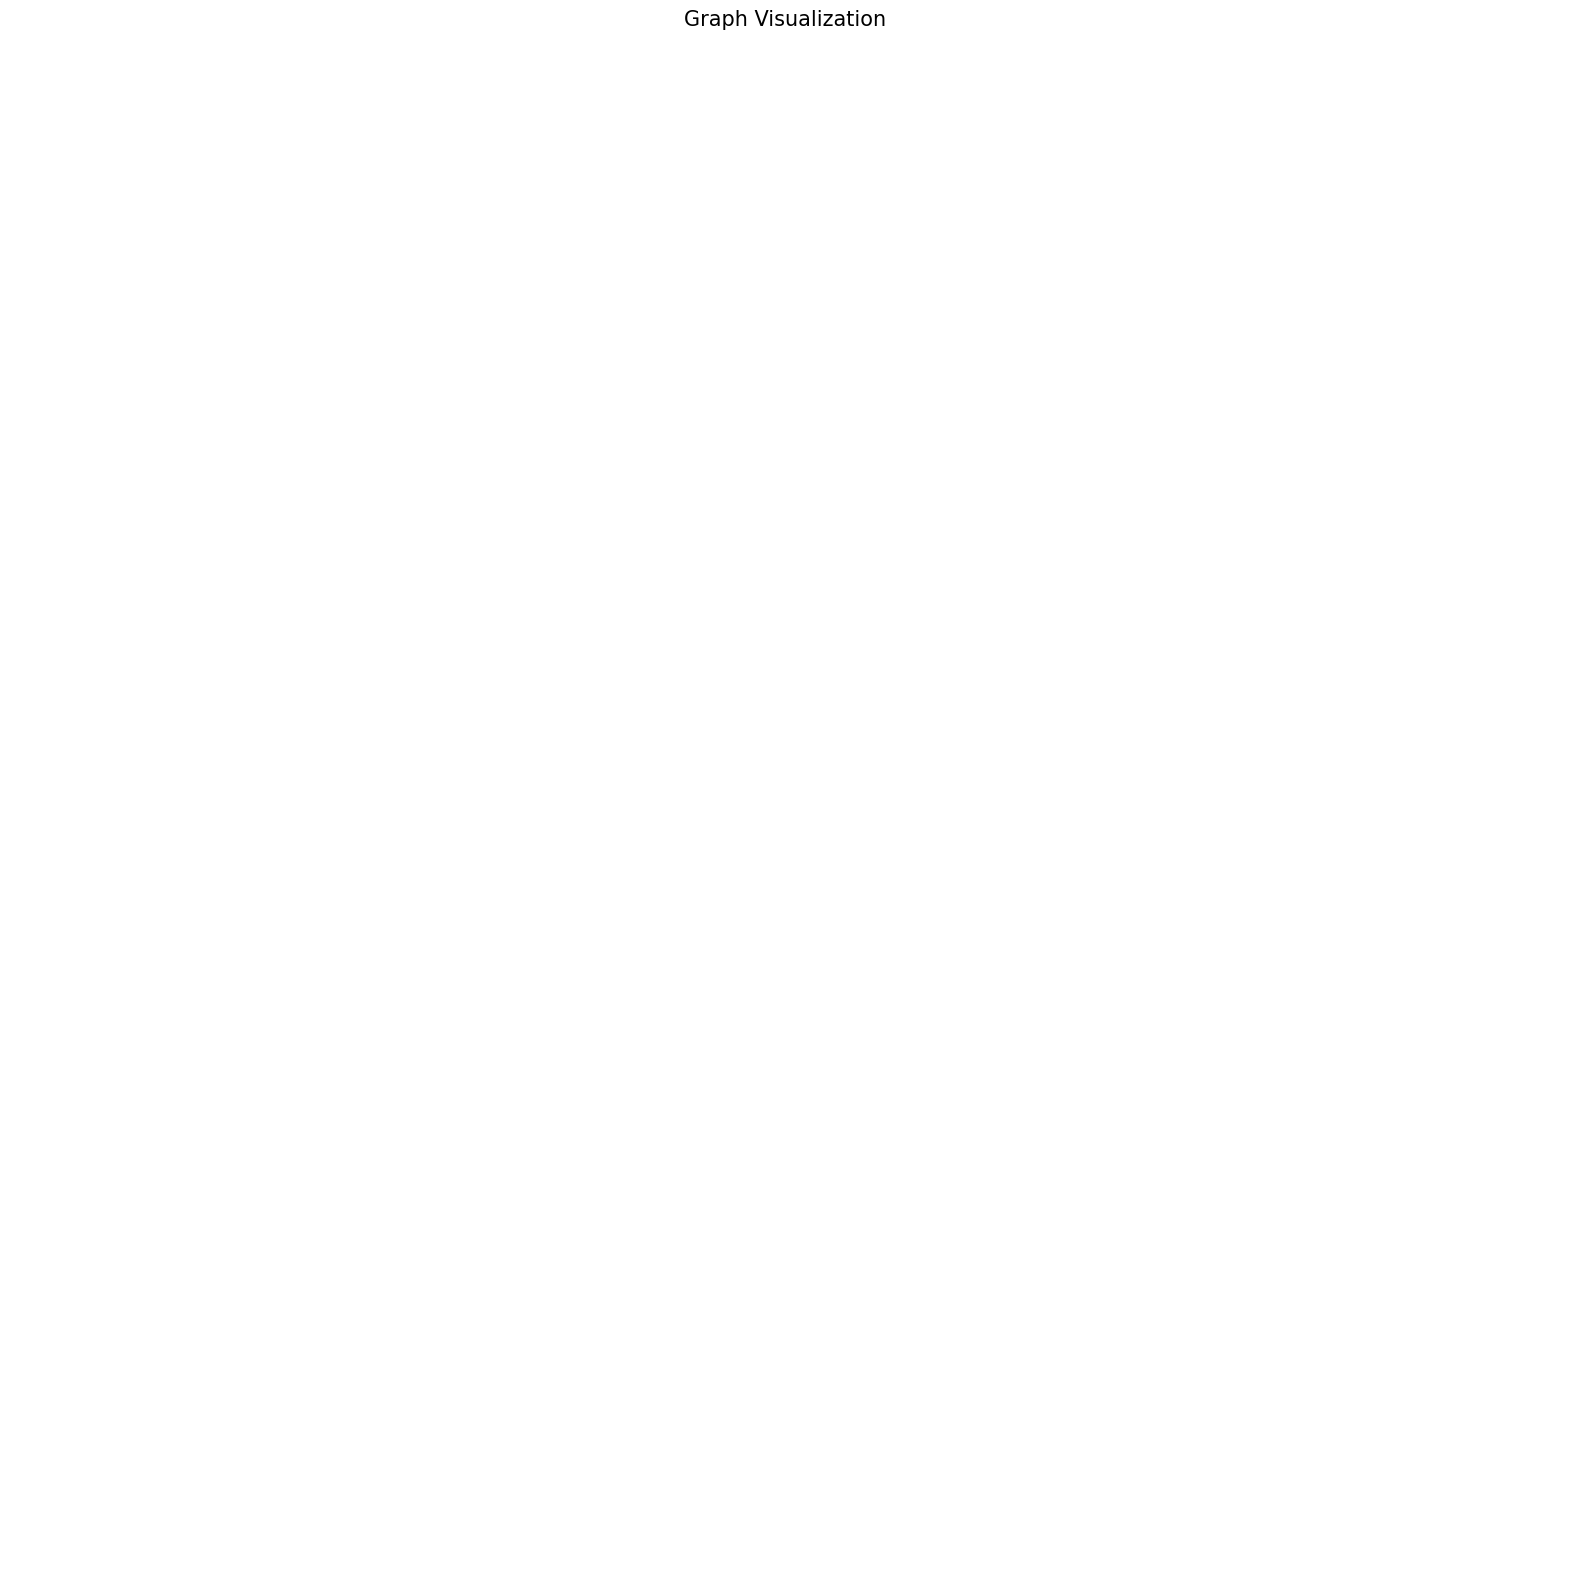

In [26]:
# Filter the data
cooc_fam

# Create the graph from the filtered dataframe
graph = nx.from_pandas_edgelist(
    cooc_fam,
    source='person1',
    target='person2',
    edge_attr='size'
)

# Generate positions for each node using Kamada-Kawai layout considering the edge weights
pos = nx.kamada_kawai_layout(graph, weight='size')

# Plotting
plt.figure(figsize=(20, 20))
# Draw nodes
nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color='skyblue', alpha=0.8)
# Draw labels
nx.draw_networkx_labels(graph, pos)
# Draw edges
edges = nx.draw_networkx_edges(graph, pos, edge_color='#505050', alpha=0.5, 
                               width=[data['size'] for _, _, data in graph.edges(data=True)])

plt.title('Graph Visualization', size=15)
plt.axis('off')  # Turn off the axis
plt.show()

I had to make couple of changes in code.Some libraries were not working due to compatibility issues. graphs were not being plotted.Also, Family df was empty df hence converted -ve numbers to +ve.( we were using family_yes > 0 and numbers were 0,-1,-2. We could have solved it by family_yes < 0 but it could have caused issus futher due to -ve numbers hence made +ve)

The most common part of speech in the analyzed text is NOUN, with a total count of 10,799 occurrences.There are 
multiple parts of the speech.

The key phrase extraction outputs from Textacy and Summa show distinct characteristics.
Textacy's output includes specific phrases like 'old man Marsh' and 'old Captain Obed Marsh', which seem directly 
extracted from the text. It also combines similar terms into sets, indicating an attempt to consolidate variations 
of key phrases.Summa's output, represented by the TR_keywords, includes more granular terms like 'things' and 
'streets', with associated scores indicating their relevance. The terms are more individualized and not grouped into
phrases, suggesting Summa focuses on singular keywords rather than multi-word phrases.

The differences indicate that Textacy might be better suited for extracting and consolidating multi-word key phrases,while Summa appears to emphasize the importance of individual terms within the text. Given the context, Textacy's approach might provide more contextual insights into the text's themes, whereas Summa offers a breakdown of key terms by their significance.

To enhance default NER extraction, we can train the model with domain-specific data and incorporating contextual rules for better entity recognition.